In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load Dataset

In [188]:
df_fct = (
    pd.read_csv('data/fct_sales.csv')
    .assign(
        purchase_timestamp=lambda x: pd.to_datetime(x['purchase_timestamp'], format='%Y-%m-%d %H:%M:%S'),
        invoice_id=lambda x: x['invoice_id'].astype('str'),
        customer_id=lambda x: x['customer_id'].astype('str')
    )
)
df_fct.info()
display(df_fct.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   invoice_id          779495 non-null  object        
 1   product_id          779495 non-null  object        
 2   customer_id         779495 non-null  object        
 3   date_id             779495 non-null  object        
 4   order_amt           779495 non-null  int64         
 5   product_price       779495 non-null  float64       
 6   purchase_timestamp  779495 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 41.6+ MB


,invoice_id,product_id,customer_id,date_id,order_amt,product_price,purchase_timestamp
251776,521910,20975,13046,2010-09-09,24,0.65,2010-09-09 13:09:00
342838,531763,22614,17878,2010-11-09,12,0.29,2010-11-09 13:50:00
100198,502749,21321,18245,2010-03-26,6,2.55,2010-03-26 13:08:00
128800,506100,17191A,16749,2010-04-27,6,3.75,2010-04-27 13:06:00
105133,503234,84926C,15808,2010-03-30,8,1.25,2010-03-30 17:10:00
675428,571441,82494L,14096,2011-10-17,2,7.46,2011-10-17 13:31:00
777582,581404,23339,13680,2011-12-08,4,2.08,2011-12-08 13:47:00
66436,498400,22355,15005,2010-02-18,6,0.85,2010-02-18 15:33:00
497084,550675,21539,15260,2011-04-20,6,4.95,2011-04-20 10:39:00
706617,574544,22952,17084,2011-11-04,24,0.55,2011-11-04 14:49:00


In [189]:
df_customer = (
    pd.read_csv('data/dim_customer.csv')
)
df_customer.info()
display(df_customer.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5894 entries, 0 to 5893
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       5894 non-null   int64 
 1   customer_country  5894 non-null   object
dtypes: int64(1), object(1)
memory usage: 92.2+ KB


,customer_id,customer_country
0,13085,United Kingdom
1,13078,United Kingdom
2,15362,United Kingdom
3,18102,United Kingdom
4,12682,France


In [190]:
df_product = (
    pd.read_csv('data/dim_product.csv')
)
df_product.info()
display(df_product.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           5315 non-null   object
 1   product_description  5315 non-null   object
dtypes: object(2)
memory usage: 83.2+ KB


,product_id,product_description
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,79323P,PINK CHERRY LIGHTS
2,79323W,WHITE CHERRY LIGHTS
3,22041,"RECORD FRAME 7"" SINGLE SIZE"
4,21232,STRAWBERRY CERAMIC TRINKET BOX


In [191]:
df_date = (
    pd.read_csv('data/dim_date.csv')
)
df_date.info()
display(df_date.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date_id      739 non-null    object
 1   year         739 non-null    int64 
 2   month        739 non-null    int64 
 3   day          739 non-null    int64 
 4   day_of_week  739 non-null    int64 
 5   is_weekend   739 non-null    bool  
 6   quarter      739 non-null    int64 
dtypes: bool(1), int64(5), object(1)
memory usage: 35.5+ KB


,date_id,year,month,day,day_of_week,is_weekend,quarter
641,2011-09-03,2011,9,3,5,True,3
196,2010-06-15,2010,6,15,1,False,2
221,2010-07-10,2010,7,10,5,True,3
255,2010-08-13,2010,8,13,4,False,3
403,2011-01-08,2011,1,8,5,True,1
61,2010-01-31,2010,1,31,6,True,1
339,2010-11-05,2010,11,5,4,False,4
464,2011-03-10,2011,3,10,3,False,1
489,2011-04-04,2011,4,4,0,False,2
504,2011-04-19,2011,4,19,1,False,2


## Analysis

### Churn Rate

In [192]:
from datetime import timedelta

CHURN_THRESHOLD_DAYS = 120

df_last_purchase = (
    df_fct
    .assign(
        date_id=lambda x: pd.to_datetime(x['date_id'])
    )
    .groupby('customer_id', as_index=False)
    .agg(
        last_purchase_date=('date_id', 'max')
    )
    .assign(
        days_since_last_purchase=lambda x: (
            ((x['last_purchase_date'].max() + timedelta(days=1)) - x['last_purchase_date'])
            .dt.days
        ),
        is_churned=lambda x: x['days_since_last_purchase'] > CHURN_THRESHOLD_DAYS
    )
)
display(df_last_purchase)
print(f'Overall churn rate: {df_last_purchase['is_churned'].mean().round(3)}')

,customer_id,last_purchase_date,days_since_last_purchase,is_churned
0,12346,2011-01-18,326,True
1,12347,2011-12-07,3,False
2,12348,2011-09-25,76,False
3,12349,2011-11-21,19,False
4,12350,2011-02-02,311,True
...,...,...,...,...
5876,18283,2011-12-06,4,False
5877,18284,2010-10-04,432,True
5878,18285,2010-02-17,661,True
5879,18286,2010-08-20,477,True


Overall churn rate: 0.47


### RFM

In [193]:
"""
Recency:
- Define snapshot date (maximum purchase date + 1)
- Get latest purchase date for each customer ID
- Get diff between snapshot and latest purchase date

Frequency:
- Get the frequency of customer's transactions

Monetary:
- Get how much the customer spends

RFM Rank:
- Calculate each of the R, F, M rank
- Classify into 3 group since the total of unique customers < 30k
- Calculate the average of each of the R, F, M rank
- Round the final rank
"""

df_rfm = (
    df_fct
    .assign(
        date_id=lambda x: pd.to_datetime(x['date_id']),
        sales=lambda x: x['order_amt'] * x['product_price']
    )
    .groupby('customer_id', as_index=False)
    .agg(
        last_purchase_date=('date_id', 'max'),
        # frequency
        frequency=('invoice_id', 'nunique'),
        # monetary
        monetary=('sales', 'sum')
    )
    .assign(
        # recency
        recency=lambda x: (
            (x['last_purchase_date'].max() + timedelta(days=1)) - x['last_purchase_date']
        ).dt.days,
        r_rank=lambda x: pd.qcut(x['recency'], q=3, labels=[1, 2, 3]),
        f_rank=lambda x: pd.qcut(x['frequency'].rank(method='first'), q=3, labels=[3, 2, 1]),
        m_rank=lambda x: pd.qcut(x['monetary'].rank(method='first'), q=3, labels=[3, 2, 1]),
        rfm_rank=lambda x: (
            x.loc[:, ['r_rank', 'f_rank', 'm_rank']]
            .mean(axis=1)
            .round()
            .astype('Int32')
        ),
        segment=lambda x: x['rfm_rank'].map({
            1: 'High-value Customers',
            2: 'Mid-value Customers',
            3: 'Low-value Customers'
        })
    )
)

display(df_rfm)

,customer_id,last_purchase_date,frequency,monetary,recency,r_rank,f_rank,m_rank,rfm_rank,segment
0,12346,2011-01-18,12,77556.46,326,3,1,1,2,Mid-value Customers
1,12347,2011-12-07,8,4921.53,3,1,1,1,1,High-value Customers
2,12348,2011-09-25,5,2019.40,76,2,2,1,2,Mid-value Customers
3,12349,2011-11-21,4,4428.69,19,1,2,1,1,High-value Customers
4,12350,2011-02-02,1,334.40,311,3,3,3,3,Low-value Customers
...,...,...,...,...,...,...,...,...,...,...
5876,18283,2011-12-06,22,2664.90,4,1,1,1,1,High-value Customers
5877,18284,2010-10-04,1,461.68,432,3,3,2,3,Low-value Customers
5878,18285,2010-02-17,1,427.00,661,3,3,3,3,Low-value Customers
5879,18286,2010-08-20,2,1296.43,477,3,2,2,2,Mid-value Customers


### Churn + RFM

In [194]:
df_merged = (
    df_rfm
    .merge(df_last_purchase[['customer_id', 'is_churned']], on='customer_id')
)

churn_by_segment = (
    df_merged
    .groupby('segment', as_index=False)
    .agg(
        churn_rate=('is_churned', 'mean')
    )
)

display(churn_by_segment)

,segment,churn_rate
0,High-value Customers,0.074266
1,Low-value Customers,0.886748
2,Mid-value Customers,0.458248


In [195]:
segment_counts = (
    df_merged
    .groupby('segment', as_index=False)
    .agg(
        customer_counts=('segment', 'count')
    )
)

display(segment_counts)

,segment,customer_counts
0,High-value Customers,1737
1,Low-value Customers,1713
2,Mid-value Customers,2431


In [196]:
result = (
    churn_by_segment.merge(segment_counts, on='segment')
)

display(result)

,segment,churn_rate,customer_counts
0,High-value Customers,0.074266,1737
1,Low-value Customers,0.886748,1713
2,Mid-value Customers,0.458248,2431


In [200]:
print("\n" + "="*50)
print("                 CHURN ANALYSIS")
print("="*50)
print(f"Churn Definition: No purchase in the last {CHURN_THRESHOLD_DAYS} days.")
print(f"Overall Customer Churn Rate: {df_merged['is_churned'].mean():.2%}")
print("-"*50)
print("\nChurn Rate by Customer Segment:\n")
print(result)
print("\n" + "="*50)


                 CHURN ANALYSIS
Churn Definition: No purchase in the last 120 days.
Overall Customer Churn Rate: 46.96%
--------------------------------------------------

Churn Rate by Customer Segment:

                segment  churn_rate  customer_counts
0  High-value Customers    0.074266             1737
1   Low-value Customers    0.886748             1713
2   Mid-value Customers    0.458248             2431



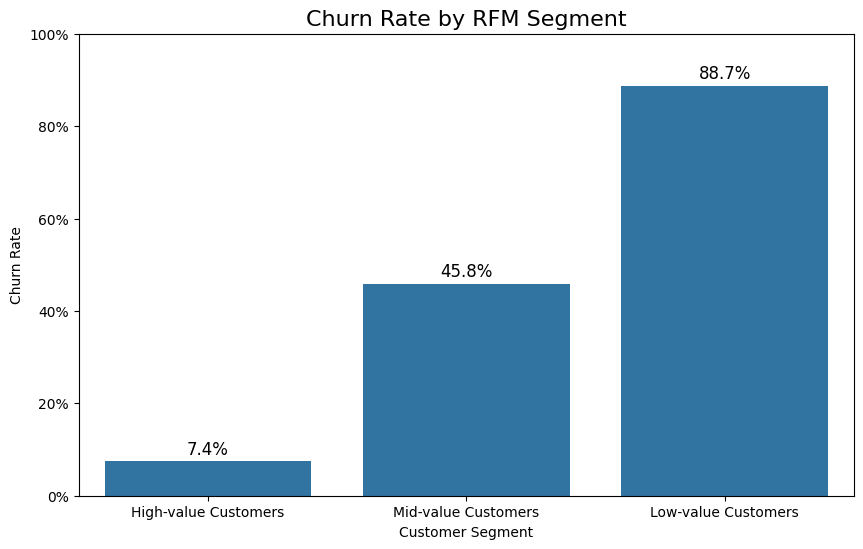

In [198]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=result, x='segment', y='churn_rate', order=['High-value Customers', 'Mid-value Customers', 'Low-value Customers'])

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=12,
                color='black')

plt.title('Churn Rate by RFM Segment', fontsize=16)
plt.ylabel('Churn Rate')
plt.xlabel('Customer Segment')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()

### Conclusion

Here are my conclusions based on each customer segment:

1. High-value Customers:

    These customers are the foundation of the company, as they represent our most loyal, engaged, and active customers.

    **Actionable strategy**:

    - Reward their loyalty

        Offer them exclusive perks, implement a VIP program, or even grant early access to new products. Our goal is to make them feel seen and appreciated.

    - Gather feedback

        This is the most important group to ask for feedback.

    - Highest priority support

        Any issue from this segment must be dealt with swiftly and flawlessly.

1. Mid-value Customers:

    This type of customer has not yet formed a strong habit with our brand, which presents our opportunity for growth by pushing them into our 'High-value' bracket.

    **Actionable strategy**:

    - Special campaign

        Email them a "welcome back" campaign with discounts, hoping to trigger the next purchase and reset their recency data.

    - Analyze their purchase history

        This allows us to recommend complementary products and make them feel seen.

1. Low-value Customers:

    This type of customer is considered highly unlikely to ever return, as they are probably one-time buyers and gift shoppers. The high churn rate for this type is not considered a failure, as this outcome was expected from this group. This is a bold reminder that we should never over-invest in this segment.

    **Actionable strategy**:

    - Low-cost maintenance

        Keep them on a general email list for major holiday promotions to keep marketing costs minimal.
